# <center> Time Series Prediction Using Recurrent Neural Network</center>

The application of recurrent neural networks in solving sequence prediction problem.

This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We first start with a simple none-machine learning common sense model as a baseline. We then train and compare several ML models including  lstm, stacked lstm and 1D convolution.

Reference: "Deep Learning with Python" book by Francois Chollet, chapter 10, section 3 as well as this [tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)


## A temperature forecasting problem
We will be working with Electricity Transformer Dataset. This
dataset record transformer’s oil temperature which is a strong predictor for electricity
consumption. We will use ETTh1 dataset which records the oil temperature for a
transformer every hour for two years. Our goal here is to predict oil temperature 96 hours into
the future.

Let's import the libraries we need and download the data into your colab session.


In [ ]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
'''
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
'''
df = pd.read_csv("/content/ETTh1.csv")


In [ ]:
df.columns

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

Let's take a look at the few records in the data:

In [ ]:
df.head(10)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000
6,2016-07-01 06:00:00,7.167,2.947,2.132,0.782,5.026,1.858,22.792000
7,2016-07-01 07:00:00,7.435,3.282,2.310,1.031,5.087,2.224,23.143999
8,2016-07-01 08:00:00,5.559,3.014,2.452,1.173,2.955,1.432,21.667000
9,2016-07-01 09:00:00,4.555,2.545,1.919,0.817,2.680,1.371,17.445999


There are 8 columns which includes
the recorded date
OT- oil temperature
& other columns are for high, middle, low useful and useless load data.

## Preparing data for Machine Learning


### Data Cleaning

The data is recorded in one hour intervals (rows are 1 hour apart). We want to do **hourly prediction**, that is, we want to predict the temprature in the next 96 hour given the previous hours. So,subsampling is not necessary as it is already inrequired format.



In [ ]:
# slice [start:stop:step], starting from index 0 take every 6th record.
#df = df[::60]

#take a look at the summary statistics of each column
df.describe().transpose()
#df.describe()

,count,mean,std,min,25%,50%,75%,max
HUFL,17420.0,7.375141,7.067744,-22.705999,5.827,8.774,11.788,23.643999
HULL,17420.0,2.242242,2.042342,-4.756000,0.737,2.210,3.684,10.114000
MUFL,17420.0,4.300239,6.826978,-25.087999,3.296,5.970,8.635,17.341000
MULL,17420.0,0.881568,1.809293,-5.934000,-0.284,0.959,2.203,7.747000
LUFL,17420.0,3.066062,1.164506,-1.188000,2.315,2.833,3.625,8.498000
LULL,17420.0,0.856932,0.599552,-1.371000,0.670,0.975,1.218,3.046000
OT,17420.0,13.324672,8.566946,-4.080000,6.964,11.396,18.079,46.007000


In [ ]:
# View the index directly
print(df.index)


RangeIndex(start=0, stop=17420, step=1)


In [ ]:
print(df.index.name)  # If it prints 'date', it means 'date' is set as the index.


None


In [ ]:
df.tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778
17419,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567


## Plotting Temperature
Le'ts plot the temprature. From this plot you can clearly see the yearly periodicity of temperature—the data spans 2 years. Since data is sampled hourly, we get roughly 365*24 data points for each year.

Yearly periodicity inspection  plot

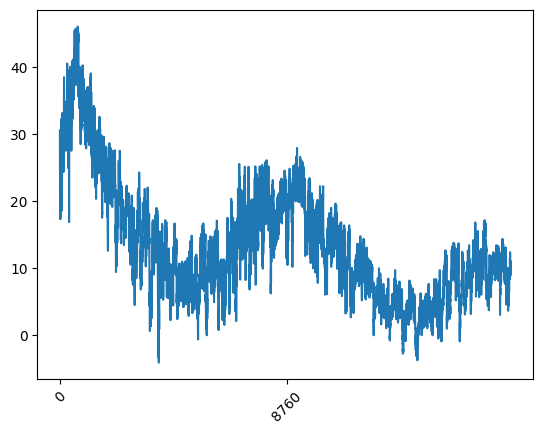

In [ ]:

from matplotlib import pyplot as plt
temprature= df['OT']
#Adjust the label frequency in x-axis to yearly intervals
plt.xticks(np.arange(0, len(temprature), 365*24), rotation=45)
plt.plot(range(len(temprature)), temprature)


Monthly periodicity inspection plot

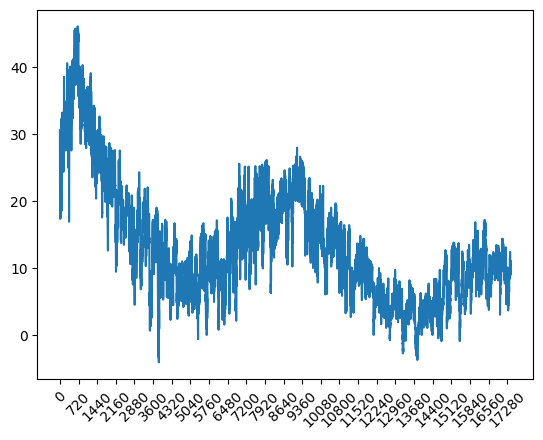

In [ ]:

from matplotlib import pyplot as plt
temprature= df['OT']
#Adjust the label frequency in x-axis to yearly intervals
plt.xticks(np.arange(0, len(temprature), 30*24), rotation=45)
plt.plot(range(len(temprature)), temprature)


Monthly periodicity is observed as peak is oberved monthly. Peak is observed at the end of month.

#1. Inspecting data
##Seasonality and Trend plots

 Many time series data exhibit patterns known as seasonality and/or trend. Seasonality refers to
patterns that repeat at regular intervals within a time series whereas Trend shows the overall decreasing
or increasing pattern of a time series. To inspect these patterns it is sometimes useful to decompose a
time series into its seasonal, trend, and remaining components. Please read this section and this section
of the book “Forecasting Principles and Practice” by Hyndman and Athanasopoulos. Then plot Oil
temperature variable and decompose it into its seasonality, trend, and remaining components.

 Reference:

 python- statsmodel package https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

 *Does oil temperature has any seasonal
pattern? What about trend?*


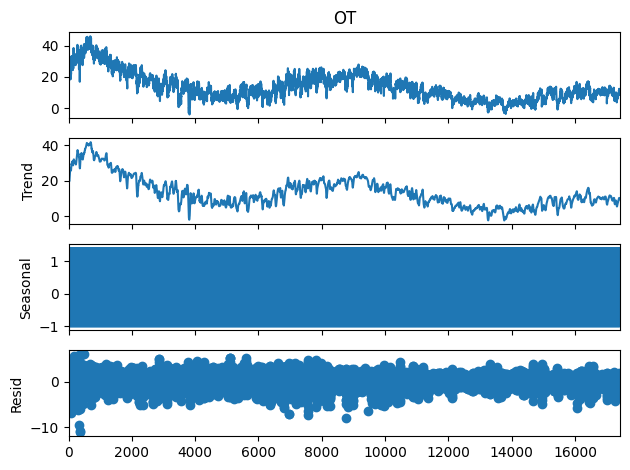

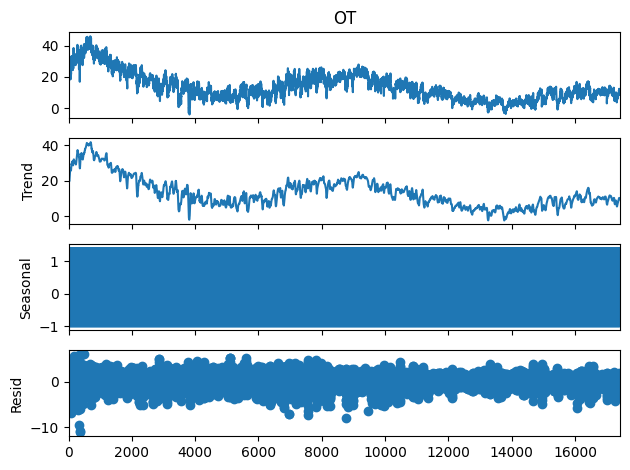

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['OT'], model='additive',period=24)
result.plot()

Trend decreases over time in a day with fluctuations. Seasonality does  show any pattern at a daily level (24 hour period). Need to look out for longer duration periods as we are given 2 year data as inspected and plotted below.

#Multiplicative seasonality is not applicable for negative values.

Now let's look at the more narrow plot of first 20 days of data. Since data is sampled hourly, we get 24 data points for each day.

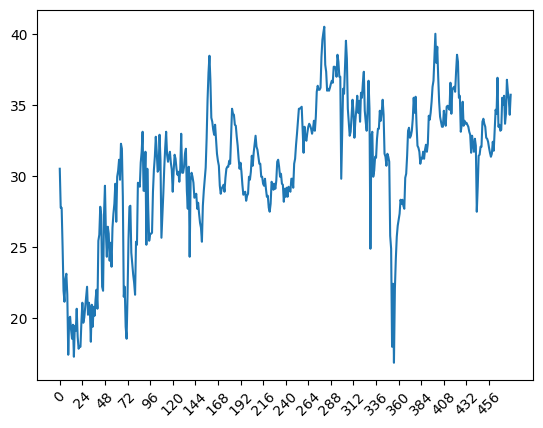

In [ ]:
from matplotlib import pyplot as plt
#adjust the label frequency in the x axis to daily intervals
plt.xticks(np.arange(0, 20*24, 24), rotation=45)
plt.plot(range(20*24), temprature[:20*24])


Daily periodicity is observed as the graph is seen an increase at the start of the day and ecreasing by thenedof the day.

Daily intervals

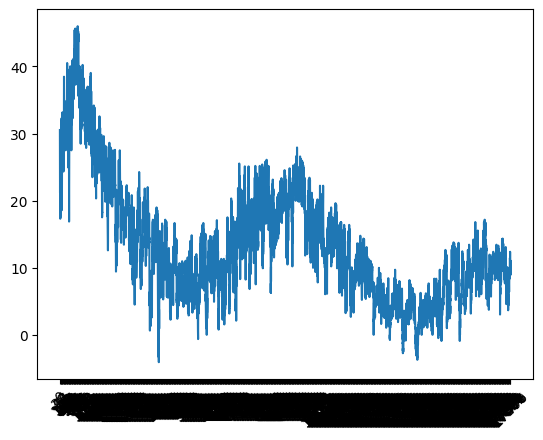

In [ ]:
from matplotlib import pyplot as plt
#adjust the label frequency in the x axis to daily intervals
plt.xticks(np.arange(0, len(temprature), 24), rotation=45)
plt.plot(range(len(temprature)), temprature)
plt.show()


On this plot we could  observe any daily periodicity.

### Feature Engineering
A useful feature engineering suggested by tensorflow is to convert the date time to time of the day and time of the month. These two features are intuitively more predictive of the temprature than the absolute date/time value.

Since the weather data has clear daily and yearly periodicity, we can look at day and month as  unit circles and then model the time of day and day of the year as a vector (with x and y components) in that circle. This way we can capture the periodicity in the data.

we can do this in two steps.
1. first convert the time stamp to seconds. Then divide it by the number of seconds in a day and multiply by $2\pi$ to get the radian of the angle of time of the day vector.

2. the x and y components of the time of the day vector are the cosine and sine of the radian, respectively

We can convert the time of month to x and y vector components in a similar fashion but instead of dividing it by the number of second in a day, we divide it by the number of seconds in a month.



In [ ]:
df.columns


Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [ ]:

#convert date time from string to datetime object.
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')

#get the time stamp in seconds
timestamp_seconds = date_time.astype('int64') // 10**9

# compute the number of seconds in a day and year
seconds_in_a_day= 24*60*60
seconds_in_a_month=(30.44)*seconds_in_a_day #average number of days in a month

#conver the timestamp to time of day and time of year x and y components
df['Day y'] = np.sin(timestamp_seconds * (2 * np.pi / seconds_in_a_day))
df['Day x'] = np.cos(timestamp_seconds * (2 * np.pi / seconds_in_a_day))
df['Month y'] = np.sin(timestamp_seconds * (2 * np.pi / seconds_in_a_month))
df['Month x'] = np.cos(timestamp_seconds * (2 * np.pi / seconds_in_a_month))



In [ ]:
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,Day y,Day x,Month y,Month x
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,-4.877283e-12,1.000000,-0.497018,0.867740
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,2.588190e-01,0.965926,-0.489536,0.871983
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,5.000000e-01,0.866025,-0.482019,0.876161
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,7.071068e-01,0.707107,-0.474466,0.880274
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,8.660254e-01,0.500000,-0.466878,0.884322


In [ ]:
df.columns

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'Day y', 'Day x',
       'Month y', 'Month x'],
      dtype='object')

Let's take a look at the data gain after the feature engineering

#2. Feature Engineering (1pt)
Make sure data is ordered by “date”, then if your inspection in the previous section shows no periodicity in
the data, remove the “date” variable

*Data is already collected date and hourly wise in an ordered way.* After the above transforamtion ,date colun is not available in dataframe.

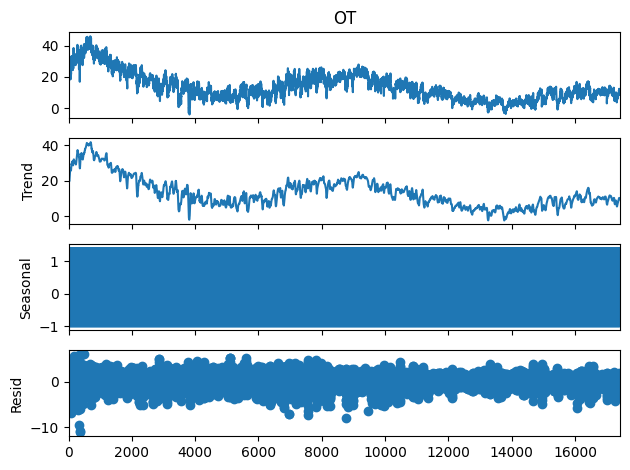

In [ ]:


# Load and sort data by date
#data = pd.read_csv("/content/ETTh1.csv", parse_dates=["date"])
#df = df.sort_values(by="date")

# Check for periodicity in 'OT' variable with decomposition
decomposition = seasonal_decompose(df['OT'], model='additive', period=24)  # Adjust period based on data frequency

# Plot the decomposed components to inspect for periodicity
decomposition.plot()
plt.show()

# If no periodicity is observed, remove the date column
#data = data.drop(columns=["date"])


Consatnt seasonality is seen. Need more clarity.

## Weekly seasonality

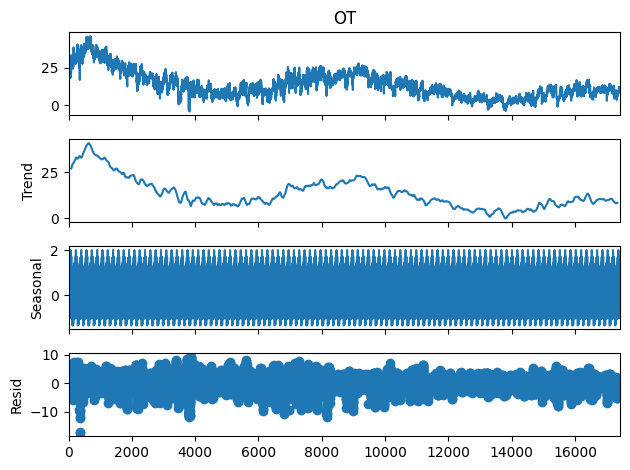

In [ ]:
# Weekly seasonality-period=24*7 (168)
decomposition_weekly = seasonal_decompose(df['OT'], model='additive', period=168)
decomposition_weekly.plot()
plt.show()




Weekly seasinality is seen from above.

## Monthly seasonality

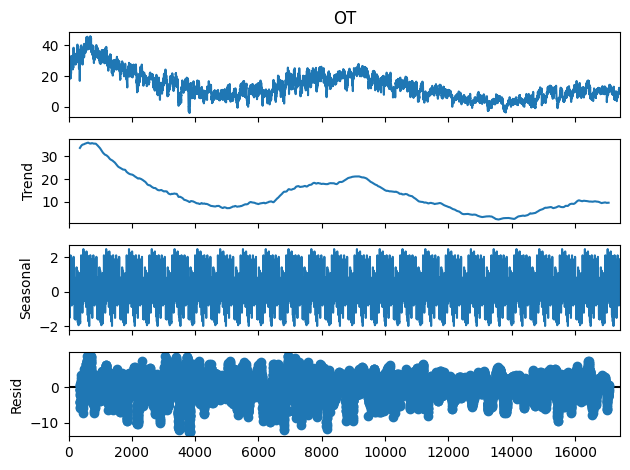

In [ ]:
# Monthly seasonality- >period=24*30
decomposition_monthly = seasonal_decompose(df['OT'], model='additive', period=720)
decomposition_monthly.plot()
plt.show()



Monthly seasonality is seen from the crests and trough patterns and fromthe number of them.

##Quarterly seasonality

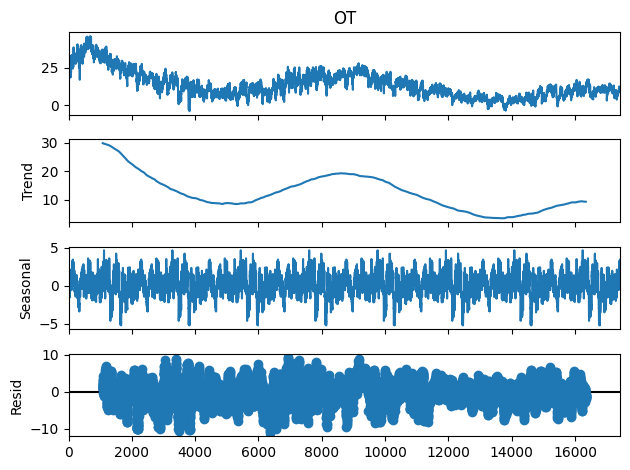

In [ ]:
# quarterly period: 24 hours/day * 90 days/quarter = 2160
decomposition_quarterly = seasonal_decompose(df['OT'], model='additive', period=2160)  #  quarterly period
decomposition_quarterly.plot()
plt.show()

A pattern is observed troughout the duration.

*2 complete cycles requires 17520 observationsbut the data has 17420 observations.* So adjusted period to half year.

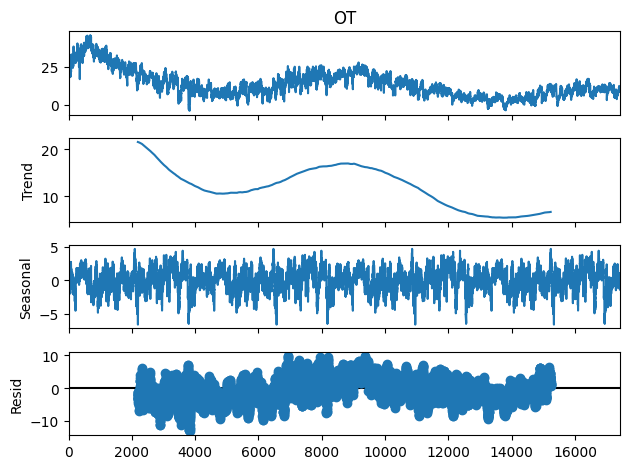

In [ ]:
# Annual seasonality->period=24*365=8760
# Half yearly seasonality->period=4380

decomposition_halfyearly = seasonal_decompose(df['OT'], model='additive', period=4380)
decomposition_halfyearly.plot()
plt.show()

A pattern is repeated within the given data of  the duration

**From all the above daily, weekly, monthly,half-yearly seasoanlity graphs, it's observed that there is a decreasing trend over time with flucttuations and  pattern is observed in the seasoanlity component. Also, noise is observed with residual component.**

In [ ]:
#  no periodicity is observed, removed the date column
#df = df.drop(columns=["date"])

##3. Split and Normalize and create time series data

Split your data into train/test/validation sets. Use the first 12 month (i.e., 12*30*24 samples) for training,
the next 6 months ( i.e., 6*30*24 samples) for validation, and the rest for testing. Create time series data,
starting with a sequence_length (i.e., window size) 120; that is, use previous 5 days to predict the
temperature 96 hours into the future. You will tune the sequence_length later.

In [ ]:
#get the number of samples
n = len(df)

# use,  the first 70% of samples for training
num_train_samples = 12 * 30 * 24

#use the next 20% of samples for testing
num_val_samples=6 * 30 * 24

#use the last 10% of samples for testing
#num_test_samples = int(n*0.25)

print("number of train samples", num_train_samples)
print("validation shape", num_val_samples)
#print("test shape", num_test_samples)

number of train samples 8640
validation shape 4320


As always, we need to scale the features before training a neural network model. Note that the the data should be normalized with the mean and standard deviation of the fraction of the data reserved for training.  This is equivalent to saying that we use the mean and standard deviation of trainining data to scale training, validation, and test data.

In [ ]:
train_mean = df[:num_train_samples].mean(axis=0)
train_std = df[:num_train_samples].std(axis=0)
df = (df - train_mean) / train_std

df.head()


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,Day y,Day x,Month y,Month x
0,-0.363102,-0.005759,-0.630676,-0.147515,1.388494,0.875092,1.460467,-6.878984e-12,1.414132,-0.722580,1.232688
1,-0.386153,0.026294,-0.650063,-0.166202,1.328900,0.924277,1.161459,3.660042e-01,1.365946,-0.711965,1.238669
2,-0.478359,-0.133975,-0.688656,-0.203056,0.972309,0.681525,1.161459,7.070659e-01,1.224674,-0.701298,1.244558
3,-0.489885,-0.037813,-0.688656,-0.184369,1.001617,0.778309,0.862561,9.999421e-01,0.999942,-0.690581,1.250357
4,-0.443782,-0.037813,-0.650063,-0.147515,1.061212,0.778309,0.525196,1.224674e+00,0.707066,-0.679814,1.256063


### Preparing timeseries Data for Supervised Learning
The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature 24 hours in to the future? In other words, we want to create a model that gets as input X five consequtive days of data (i.e.,120 hours) and predicts the temprature 24 hours after the last measurement data in X.

Suppose that the sample at time step $t_0$  (the first row in the data) is $s_0$ . We can convert this problem to a supervised learning problem by creating samples of the following form:

$X0= (s_0 , s_1, ...,s_{119})$    $Y0=t_{143}$  where $t_{143}$ is the temprature at time step 143 (that is the temprature column in 143th row of the data). This means the first 120 rows are used to predict the temprature in row 143


The next input/output pairs would be:

$X1=(s_1,s_2,...,s_{120})$, $Y1=t_{144}$ .

$X2=(s_2,s_3,...,s_{121})$, $Y2=t_{145}$

and so on.


This is as if you are taking a window of size 120 and slide it down by one row to create the next input.

We could write a Python generator to do this, but there’s a built-in dataset utility in Keras
that does just that <code>timeseries_dataset_from_array</code>, so we can save ourselves some work by using it. You can check the documentation [here](!https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array).

<code>timeseries_dataset_from_array</code> gets raw time series data and returns a <code>tf.data.Dataset</code> object with batches of (X,Y) pairs similar to the ones mentioned above. It takes the following arguments:
* <code>data</code>: is the raw data which could be a Numpy array containing consecutive data points
* <code>targets</code> targets[i] should be the target/output corresponding to the window that starts at index i (i.e., $Y_i$).
* <code>sequence_length</code> length of the window. In other words, how many consecutive past observations you want to use to predict the target

To understand what <code>timeseries_dataset_from_array</code> does, let’s take a look at a simple example.  Let’s say you’re using data = [0 1 2 3 4 5 6] and sequence_length=3, and targets=[3,4,5,6] then timeseries_dataset_from_array will generate the following samples, we call each of these sample a *sequence*:

$X$=[0,1,2],$Y$=[3]

$X$=[1 2 3],$Y$=[4]

$X$=[2 3 4],$Y$=[5]

$X$=[3 4 5],$Y$=[6]





Now that we know what <code>timeseries_dataset_from_array</code> does let's use it to create  training, test, and validation sequences from the weather data. We set <code>sequence_length=120</code> because we want to use the past 120 observations for prediction.

One can pass <code>timeseries_dataset_from_array</code> function a <code>start_index</code> and an <code>end_index</code> to create sequences on a slice of data from <code>start_index</code> to <code>end_index</code>. This is useful for splitting time series data to train/test/validation. Training data starts from index 0 and ends at index num_train_samples.The validation data starts at index num_train_samples and ends at index num_train_samples+num_val_samples, and the test data starts at index num_train_samples+num_validation_samples and goes to the end of the data.  

Since we want to forecast the temprature with a 24 hour delay ( that is, 24 hours into the future), we need to remove the last 24+sequence_length-1 observations from our dataframe  because we don't have a target value for those observations (hence, <code>data=df[:-delay].to_numpy()</code>). Likewise, our first target (temprature) starts at index 24+sequence_length-1 instead of index 0 ( hence, <code>targets=df['T (degC)'][delay:].to_numpy()</code>)

In [ ]:
#sequence_length is the number of past observations you want to use for prediction.
sequence_length = 120
batch_size = 256

#Horizon is the forecasting interval, that is, how many time steps into the future you want to predict.
#Create time series data,
#starting with a sequence_length (i.e., window size) 120; that is, use previous 5 days to predict the
#temperature 96 hours into the future
horizon= 96

# delay is where the index for y should start
delay=sequence_length+horizon-1

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay],
targets=df['OT'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=0,
end_index=num_train_samples)


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay],
targets=df['OT'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)


test_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay].to_numpy(),
targets=df['OT'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=num_train_samples + num_val_samples)





Each Dataset yields a tuple (samples, targets), where samples is a batch of 256 sequences,each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures.

Let's take a look at the first batch in the training dataset. We can iterate the dataset to get batches of training data. Each batch is of shape (256,120,19) where 256 is the number of samples in the batch, 120 is the sequence_length, and 19 is the number of variables in each sequence.  in other words, each sequence has 120 consecutive measurements of 19 variables.

targets is a vector of shape 256. A target for each sequence in the batch is the temprature value 24 hours after the last measurement in the sequence.

In [ ]:
for samples, targets in test_dataset.take(1):
    print(f"samples.shape:{samples.shape}  targets.shape:{targets.shape}")
    print(f"x={samples[0]},y={targets[0]}")

samples.shape:(256, 120, 11)  targets.shape:(256,)
x=[[ 0.24758926  0.34683404  0.38669794 ...  1.41413172 -1.20098617
  -0.76796675]
 [ 0.29369224  0.02629444  0.31585317 ...  1.36594635 -1.20767228
  -0.75782453]
 [ 0.24758926 -0.03781344  0.24500849 ...  1.22467399 -1.21427034
  -0.74762556]
 ...
 [ 0.43200087  0.05834836  0.489613   ...  0.99994213 -1.31172068
   0.58698265]
 [ 0.28216646  0.2827261   0.43163264 ...  1.22467399 -1.30667331
   0.59802093]
 [ 0.54725808  0.60326569  0.63130245 ...  1.36594635 -1.30153058
   0.60901567]],y=-1.4064760156116154


## A common-sense, None-machine learning baseline

Before we start using black-box deep-learning models to solve the temperature prediction
problem, let’s try a simple, common-sense approach. It will serve as a sanity
check, and it will establish a baseline that you’ll have to beat in order to demonstrate
the usefulness of more-advanced machine-learning models. Such common-sense baselines
can be useful when you’re approaching a new problem for which there is no
known solution (yet). A classic example is that of unbalanced classification tasks,
where some classes are much more common than others. If your dataset contains 90%
instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such
a classifier is 90% accurate overall, and any learning-based approach should therefore
beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary
baselines can prove surprisingly hard to beat.
In this case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as well
as periodical with a daily period. Thus a common-sense approach is to always predict
that the temperature 24 hours from now will be equal to the temperature right now.
Let’s evaluate this approach, using the mean absolute error (MAE) metric.

Recall that the data is normalized. Therefore, to get MAE in the original scale we need to un-normalize both predictions and targets first. To un-normalize, we simply multiply the data by standard deviaion and add the mean to it.


Created a baseline model that always forecasts the last time step in each sample. Specifically,
the baseline model will forecast the oil temperature 96 hours into the future by predicting it to be
the value observed at the last time step in the input (i.e., it predicts the future temperature to be
the same as the value 96 time steps earlier).
Find the mean absolute error of this baseline model.

In [ ]:
df.columns.get_loc('OT')

6

In [ ]:
#un-normalize the predictions and targets, to convert them back to celsius so we can interpret the error.
#To un_normalize, reverse the normalization process, that is, multiply by train_std and add train_mean
def unnormalize(preds, targets, mean, std):
   preds=preds* std + mean
   targets= targets*std+mean
   return preds, targets

def evaluate_model(dataset, model=None):
  total_abs_err = 0.
  num_sequences = 0
  # the index of the temperature variable in the data. temperature is the 6th column in df so its index is 1.
  temp_index=6
  for samples, targets in dataset:

    #if model is None, use commonsense baseline, that is predict the target to be its last measurement in the input sequence
    if model==None:
      #for each sequence in the batch predict the target to be samples[:, -1, temp_index] which is is the last temperature measurement in the input sequence
      #index -1 in samples[:, -1, temp_index] means the last time step in the sequence
      preds = samples[:, -1, temp_index]

    #if model is not None, get its predictions
    else:
      preds= model.predict(samples, verbose=0).flatten()

    preds, targets=unnormalize(preds, targets, train_mean.iloc[temp_index], train_std.iloc[temp_index])

    # add the absolute difference between the predictions and taragets to total_abs_err
    total_abs_err += np.sum(np.abs(preds - targets))

    # add the number of sequences in this batch to num_sequences
    num_sequences += samples.shape[0]

  #get the average absolute error
  return total_abs_err / num_sequences


print(f"Validation MAE Baseline: {evaluate_model(val_dataset):.2f}")


Validation MAE Baseline: 0.79


This common-sense baseline achieves a validation MAE of 0.79 degrees Celsius. So if you always assume that the temperature 96 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. It’s not too bad, but unreliable  heuristic. Expecting  deep learning to do better.

##5. LSTM and 1d Convolution models

## The first Recurrent Baseline
"Let's try using a recurrent neural network (RNN) model for processing this sequence data. An RNN is a goodd fit for sequence data because it uses the temporal ordering of data points, learning from patterns over time. Below, is a simple recurrent model with one LSTM layer followed by a Dense output layer.

Our train, test, and validation datasets consist of batches of 3D arrays with dimensions [batch_size, sequence_length, num_features]. This means each batch contains multiple examples (the batch size), each example being a sequence of data points (sequence length), and each data point containing multiple features.

In Keras, an LSTM layer takes this 3D input and processes the sequence, returning either:

* The hidden state for each time step across the sequence ([batch_size, sequence_length, hidden_units]), if return_sequences=True.
* The hidden state for only the last time step ([batch_size, hidden_units]), if return_sequences=False (which is the default setting).

In our case, we use the default setting where the LSTM returns the hidden state for the last time step. This is particularly useful if we are only interested in a summary representation of the entire sequence. The hidden state from the lstm layer then goes to an output Dense layer. This
Dense layer doesn't use an activation function, which is typical for regression problems where the goal is to predict a real-valued output. For the loss function, we'll use Mean Absolute Error (MAE), which aligns well with our evaluation metric and makes the model output directly comparable to our simpler baseline models.

In [ ]:
#every sample in train/validation/test is a 2d tensor of shape (sequence_length, num_features)
num_features=df.shape[-1]
def build_lstm(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))
  x = layers.LSTM(16)(inputs)
  outputs = layers.Dense(1)(x)
  lstm_model = keras.Model(inputs, outputs)
  return lstm_model


lstm_model= build_lstm(sequence_length, num_features)

# check point the model with lowest validation loss
checkpoint= keras.callbacks.ModelCheckpoint("temp_lstm.keras",save_best_only=True)
#add a learning rate schedule to reduce the learning rate when validation loss plateaus
rop= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

#stop trianing if validation loss does not improve for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)


lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = lstm_model.fit(train_dataset,
epochs=100,
validation_data=val_dataset,
callbacks=[checkpoint, early_stopping, rop])

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.9237 - mae: 0.7627 - val_loss: 0.6722 - val_mae: 0.6792 - learning_rate: 0.0010
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.6802 - mae: 0.6445 - val_loss: 0.6064 - val_mae: 0.6554 - learning_rate: 0.0010
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.5392 - mae: 0.5701 - val_loss: 0.5497 - val_mae: 0.6285 - learning_rate: 0.0010
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.4501 - mae: 0.5235 - val_loss: 0.5002 - val_mae: 0.6011 - learning_rate: 0.0010
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.3894 - mae: 0.4902 - val_loss: 0.4582 - val_mae: 0.5752 - learning_rate: 0.0010
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.3465 - mae: 0.4653 - val_loss: 0.4252 - val_mae: 0.5534 - learning_rate: 0.0010
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.3136 - mae: 0.4448 - val_loss: 0.4009 - val_mae: 0.5366 - learning_rate: 0.0010


In [ ]:
print(lstm_model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 11)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,620 (14.14 KB)

 Trainable params: 1,809 (7.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,811 (7.08 KB)

None


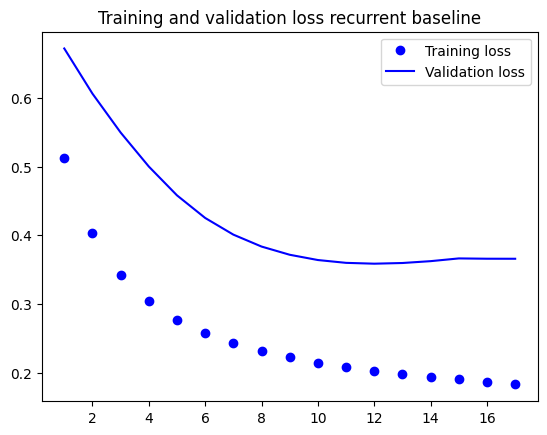

In [ ]:
#print(lstm_model.summary())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss recurrent baseline')
plt.legend()
plt.show()

Now let's evalueate the lstm model.

In [ ]:

# load the checkpointed model and compute its test MAE
lstm_model = keras.models.load_model("temp_lstm.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=lstm_model):.2f}")


Validation MAE lstm: 1.06


Validation mae  is higher than training mae.Validation loss is higher than training loss and also there is a significant gap between them which indicates **overfitting**.


 LSTM model achieved a validation MAE as low as 1.06 degree Celsius.


***LSTM model has not performed better than the baseline model as validation mae of lstm model,1.06 is less than that of the rnn model which is observed as 0.79.*** Hence, LSTM model can beat the baseline model in terms of performance as the error is less and this can be further tuned to improve the performance and beat baseline model.

## Tune the RNN model as follows:
▪ Tune the architecture of the model ( Stack LSTM or GRU layers and/or add several
dense+dropout layers after LSTM/GRU layers and before the final layer)

▪ Go back to where you create time series datasets and tune the sequence_length
you can tune it in the range (48,96, 120, 336)

▪ Add learning rate scheduling and tune the initial learning rate

▪ Use “AdamW” (Adam with weight decay, covered in module 5 lecture) optimizer
instead of Adam to better regularize your model.
o You can use hyperband to automate the hyperparameter optimization if you want.
Otherwise, if you do it manually please list the hyperparameter combinations you used
and their corresponding mae

# Stacking recurrent layers

Because our model is not overfitting but seem to have hit a performance bottleneck, we should consider increasing the capacity of the network. Recall the description of the universal machine-learning workflow: it’s generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle at which point you start taking basic steps to mitigate overfitting, such as using dropout. But as long as you aren’t overfitting too badly, you can increase the capacity.

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks.

In the example below, we’ll try a stack of two dropout-regularized recurrent layers. For a change, we’ll use GRU layers instead of LSTM. GRU (Gated Recurrent Unit) is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

To stack recurrent layers on top of each other in Keras, all intermediate layers (except the last lstm layer) should return their full sequence of outputs (a 3D tensor) rather than their output at
the last timestep. This is done by specifying <code>return_sequences=True</code> .



In [ ]:
num_features=df.shape[-1]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

def build_stacked_lstm(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))
  x = layers.GRU(32, return_sequences=True)(inputs)
  x = layers.GRU(32)(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model

stacked_lstm_model= build_stacked_lstm(sequence_length, num_features)
# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("temp_stacked_lstm.keras",save_best_only=True)

#add a learning rate schedule to reduce the learning rate when validation loss plateaus
rop= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


# AdamW optimizer
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
# Compile with AdamW optimizer and learning rate scheduling
adamw_optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
stacked_lstm_model.compile(optimizer=adamw_optimizer, loss="mse", metrics=["mae"])
history = stacked_lstm_model.fit(train_dataset,
epochs=150,
validation_data=val_dataset,
callbacks=[checkpoint, early_stopping,rop])

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - loss: 2.5956 - mae: 1.2967 - val_loss: 0.7676 - val_mae: 0.7376 - learning_rate: 0.0010
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - loss: 0.8903 - mae: 0.7424 - val_loss: 0.5246 - val_mae: 0.6147 - learning_rate: 0.0010
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - loss: 0.5428 - mae: 0.5770 - val_loss: 0.3055 - val_mae: 0.4687 - learning_rate: 0.0010
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - loss: 0.4528 - mae: 0.5315 - val_loss: 0.2218 - val_mae: 0.3938 - learning_rate: 0.0010
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - loss: 0.3761 - mae: 0.4836 - val_loss: 0.1816 - val_mae: 0.3505 - learning_rate: 0.0010
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - loss: 0.3703 - mae: 0.4818 - val_loss: 0.1783 - val_mae: 0.3471 - learning_rate: 0.0010
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - loss: 0.3147 - mae: 0.4427 - val_loss: 0.1802 - val_mae: 0.3489 - learning_rate:

At 10/100 of learning raate schedued compilationof the model, achieved loss: 0.3106 - mae: 0.4374 - val_loss: 0.2295 - val_mae: 0.3981 - learning_rate: 1.0000e-04. Even though validation loss is lower than the training loss, val-mae is higher than the train loss.

At 9/150: achieved loss: 0.3382 - mae: 0.4584 - val_loss: 0.2225 - val_mae: 0.3945 - learning_rate: 1.0000e-04. Val loss and mae are less than the training loss and training mae correspondingly.

At 11/150

loss: 0.2784 - mae: 0.4152 - val_loss: 0.1999 - val_mae: 0.3709 - learning_rate: 1.0000e-04

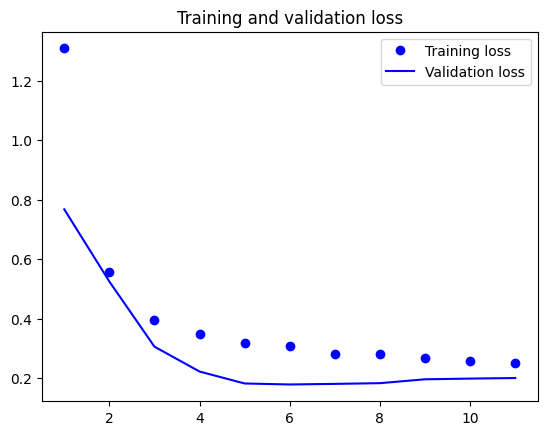

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Let's evaluate the stacked lstm model on the validation data.

In [ ]:
# load the checkpointed model and compute its test MAE
stacked_lstm_model = keras.models.load_model("temp_stacked_lstm.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=stacked_lstm_model):.2f}")


Validation MAE lstm: 0.73


You can see that the added layer does improve the results a bit, though not significantly and the model is not overfitting and also losses are not converged. Hence,further training may improve the performance.

Stacked lstm model performed better than a baseline model.

##Tuning with Hyperband

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
#Referred lab lectures
#!pip install -q -U keras-tuner
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import Hyperband

def build_model(hp):
    # Hyperparameters
    sequence_length = hp.Choice('sequence_length', values=[48, 96, 120, 336])
    num_units = hp.Choice('num_units', values=[16, 32, 64])
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    initial_lr = hp.Float('initial_lr', min_value=1e-4, max_value=1e-2, sampling="log")

    # Learning rate schedule
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10000,
        alpha=1e-2
    )
    optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

    # Model architecture
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = inputs
    for _ in range(num_layers):
        x = layers.GRU(num_units, return_sequences=True)(x)
    x = layers.GRU(num_units)(x)  # Final GRU layer without return_sequences
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model




In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=20,
    factor=3,
    directory='hyperband_dir',
    project_name='time_series_rnn_ElectricityTransformer'
)
#  early stopping to avoid unnecessary long training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,min_delta=1e-4, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(
log_dir="/content/drive/MyDrive/tensorboard_logs/hyperband",
histogram_freq=1
)
#remove the log directory if already exists
!rm -rf "/content/drive/MyDrive/tensorboard_logs/hyperband"
#  the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping,tensorboard],verbose = 1)




Trial 90 Complete [00h 04m 57s]
val_mae: 0.3581610321998596

Best val_mae So Far: 0.3581610321998596
Total elapsed time: 02h 59m 52s


In [ ]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters:\n"
      f"Sequence Length: {best_hps.get('sequence_length')}\n"
      f"Num LSTM/GRU Units: {best_hps.get('num_units')}\n"
      f"Num Layers: {best_hps.get('num_layers')}\n"
      f"Dense Units: {best_hps.get('dense_units')}\n"
      f"Dropout Rate: {best_hps.get('dropout_rate')}\n"
      f"Initial Learning Rate: {best_hps.get('initial_lr')}")

Best Hyperparameters:
Sequence Length: 96
Num LSTM/GRU Units: 32
Num Layers: 2
Dense Units: 64
Dropout Rate: 0.30000000000000004
Initial Learning Rate: 0.005042128163304707


**Best Hyperparameters obtained**

With max-epochs=50:

Sequence Length: 96

Num LSTM/GRU Units: 32

Num Layers: 2

Dense Units: 64

Dropout Rate: 0.30000000000000004

Initial Learning Rate: 0.005042128163304707

Best model- Validation MAE lstm:  0.36 is better than baseline model(0.73) on non- stationary time series data of electricity transformer

#Best Model (non-stationary data)

In [ ]:
sequence_length = 96

num_units = 32
num_layers = 2
dense_units = 64
dropout_rate = 0.3
initial_learning_rate = 0.005042128163304707
num_features=df.shape[-1]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

def build_best_lstm(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))
  x = layers.GRU(32, return_sequences=True)(inputs)
  x = layers.GRU(32)(x)
  x = layers.Dropout(0.3)(x)
  # Add Dense layer with 64 units
  x = layers.Dense(64)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model

best_lstm_model= build_best_lstm(sequence_length, num_features)
# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("best_lstm_non-stationary_model.keras",save_best_only=True)

#add a learning rate schedule to reduce the learning rate when validation loss plateaus
rop= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


# AdamW optimizer
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
# Compile with AdamW optimizer and learning rate scheduling
adam_optimizer = keras.optimizers.Adam(learning_rate=0.005042128163304707, weight_decay=1e-5)
best_lstm_model.compile(optimizer=adam_optimizer, loss="mse", metrics=["mae"])
history = best_lstm_model.fit(train_dataset,
epochs=150,
validation_data=val_dataset,
callbacks=[checkpoint, early_stopping,rop])

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - loss: 1.2089 - mae: 0.8863 - val_loss: 0.9564 - val_mae: 0.8269 - learning_rate: 0.0050
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - loss: 1.4488 - mae: 0.9753 - val_loss: 0.8480 - val_mae: 0.7902 - learning_rate: 0.0050
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - loss: 1.9376 - mae: 1.0974 - val_loss: 0.5650 - val_mae: 0.6609 - learning_rate: 0.0050
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - loss: 1.5569 - mae: 0.9829 - val_loss: 0.3567 - val_mae: 0.5066 - learning_rate: 0.0050
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - loss: 0.7582 - mae: 0.6926 - val_loss: 0.3499 - val_mae: 0.5024 - learning_rate: 0.0050
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - loss: 0.3573 - mae: 0.4756 - val_loss: 0.2661 - val_mae: 0.4191 - learning_rate: 0.0050
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - loss: 0.2996 - mae: 0.4388 - val_loss: 0.1778 - val_mae: 0.3313 - learning_rate: 

In [ ]:
#sequence_length is the number of past observations you want to use for prediction.
sequence_length = 96
batch_size = 256

#Horizon is the forecasting interval, that is, how many time steps into the future you want to predict.
#Create time series data,
#starting with a sequence_length (i.e., window size) 120; that is, use previous 5 days to predict the
#temperature 96 hours into the future
horizon= 96

# delay is where the index for y should start
delay=sequence_length+horizon-1

validation_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay],
targets=df['OT'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)
#load the checkpointed model and compute its test MAE
best_lstm_model = keras.models.load_model("best_lstm_non-stationary_model.keras")

print(f"Validation MAE lstm: {evaluate_model(validation_dataset, model=best_lstm_model):.2f}")

Validation MAE lstm: 0.70


*Best model obtained from hyper parameter tuning resulted in  validation MAE of 0.70*. it beats the baseline model.

## Trying 1D convolutional layers
After learning about convolutional neural networks (convnets) and how
they perform particularly well on computer vision problems, due to their ability to operate convolutionally, extracting features from local input patches and allowing for representation modularity and data efficiency. The same properties that make convnets excel at computer vision also make them highly relevant to sequence processing.
Time can be treated as a spatial dimension, like the height or width of a 2D image. Such 1D convnets can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost. It has long been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting.

The convolution layers introduced previously were 2D convolutions, extracting 2D
patches from image tensors and applying an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences. See figure below from Deep learning with python, section 6.

 ![cat to tensor](https://drive.google.com/uc?export=view&id=1qeCKzYVxuUpuXgr13ZgBAYhh80NAZf8g)

Such 1D convolution layers can recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations). For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus able to learn about word morphology.

We can thus build 1D convnets, strictly analoguous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).
Example: temperature forecasting problem. We’ll pick an initial window length of 24,so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (viaMaxPooling1D layers), we’ll reduce the window size accordingly.
Note that we used MaxPooling1D and GlobalAverage1D layers because we are doing the pooling and averaging along the temporal dimension ( i.e., sequence length)




In [ ]:
def build_1dconv(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))

  # a 1D convolutional layer with 8 filters and a kernel/window of size 24
  x = layers.Conv1D(8, 24, activation="relu")(inputs)
  # a 1D convolutional layer with 8 filters and a kernel of size 12
  x = layers.MaxPooling1D(2)(x)

  # a 1D convolutional layer with 8 filters and a kernel of size 12
  x = layers.Conv1D(8, 12, activation="relu")(x)
  x = layers.MaxPooling1D(2)(x)

  # a 1D convolutional layer with 8 filters and a kernel of size 6
  x = layers.Conv1D(8, 6, activation="relu")(x)

  # a golobal average pooling layer that takes the global average along the temporal dimension
  x = layers.GlobalAveragePooling1D()(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model
conv1D_model= build_1dconv(sequence_length, num_features)

conv1D_model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 120, 11)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 97, 8)               │           2,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 18, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 13, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Now let's train this model.

In [ ]:

# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("temp_conv1d.keras",save_best_only=True)
conv1D_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = conv1D_model.fit(train_dataset,
epochs=150,
validation_data=val_dataset,
callbacks=[checkpoint, rop])

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 1.3896 - mae: 0.9782 - val_loss: 0.7382 - val_mae: 0.7225 - learning_rate: 0.0010
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.7508 - mae: 0.6796 - val_loss: 1.0992 - val_mae: 0.9106 - learning_rate: 0.0010
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.3883 - mae: 0.4884 - val_loss: 0.6256 - val_mae: 0.6776 - learning_rate: 0.0010
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 1.5481 - mae: 0.9748 - val_loss: 0.8942 - val_mae: 0.8337 - learning_rate: 0.0010
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.3938 - mae: 0.4807 - val_loss: 0.7108 - val_mae: 0.7236 - learning_rate: 0.0010
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.3178 - mae: 0.4431 - val_loss: 0.6112 - val_mae: 0.6718 - learning_rate: 0.0010
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.2579 - mae: 0.3994 - val_loss: 0.4686 - val_mae: 0.5770 - learning_rate: 0.0010
Epoch 

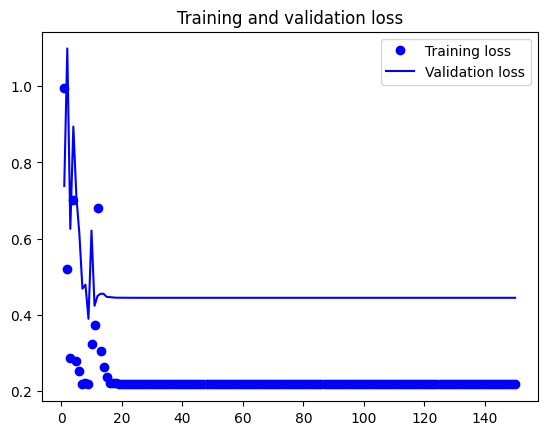

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##Optimizer- rmsprop
At 50 epochs of training:

loss: 0.2571 - mae: 0.3921 - val_loss: 0.4055 - val_mae: 0.5306 - learning_rate: 1.0000e-17

At 150 epochs:

loss: 0.2089 - mae: 0.3587 - val_loss: 0.4271 - val_mae: 0.5476 - learning_rate: 0.0000e+00

##Optimizer Adam

At 150 epochs:

loss: 0.2886 - mae: 0.4130 - val_loss: 0.5036 - val_mae: 0.5958 - learning_rate: 0.0000e+00

Gap between losses reduced  with adam comparedto rmsprop. Overfitting occurred and neeeds improvement.

Let's evaluate the this conv1d model on the validation dataset

In [ ]:
# load the checkpointed model and compute its test MAE
conv1D_model = keras.models.load_model("temp_conv1d.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=conv1D_model):.2f}")

Validation MAE lstm: 1.09


This model achieves a validation MAE of about 1.09 degrees, did not show improvement from the common-sense baseline (MAE-0.79).



**Stacked LSTM model has achieved the lowest validation mae compared to all the above models.** Also, It performed a lot more than the baseline model.

##Back to Feature Engineering making the time series Stationary & training on different models

1) baseline model

2) LSTM model

3) stacked lstm model & hyperband tuning

4) 1D conv model


“A stationary time series is one whose statistical properties do not depend on the time at which the
series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend
and seasonality will affect the value of the time series at different times. “ While RNNs can capture
trends and seasonality, it is often beneficial to make the time series stationary prior to training an
RNN model. This is because making the series stationary can improve the stability and efficiency of
the model training. Stationarity allows the model to better capture the underlying temporal
dependencies without being overwhelmed by changing means or variances, leading to more
accurate forecasts and faster convergence during training.
One common technique to make a time series stationary is differencing, which involves subtracting
the previous value from the current value. Differencing helps remove trends and ensures that the
series has a more consistent mean and variance over time, which allows the RNN to focus on
learning patterns that are inherent to the data rather than trying to fit the trends.

Go back to step 2 (feature engineering) and replace
the target column (oil temperature) with its difference series.
 (note: only compute difference series for the target
column, the other variables remain unchanged). After differencing, drop the first row where oil
temperature is NA and reset index.
Note: differencing should be done at the beginning before normalization
Repeat steps 3-6 above where the oil temperature is replaced with its difference series and answer
the following question:

How do your models perform compared to the baseline model?

In [ ]:
import pandas as pd
df = pd.read_csv("/content/ETTh1.csv")
#  df is  DataFrame and 'OT' is the target column
#  Perform differencing on the 'oil_temperature' column
data=df.copy()
#df['OT_diff'] = df['OT'].diff()




In [ ]:

#convert date time from string to datetime object.
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')

#get the time stamp in seconds
timestamp_seconds = date_time.astype('int64') // 10**9

# compute the number of seconds in a day and year
seconds_in_a_day= 24*60*60
seconds_in_a_month=(30.44)*seconds_in_a_day #average number of days in a month

#conver the timestamp to time of day and time of year x and y components
df['Day y'] = np.sin(timestamp_seconds * (2 * np.pi / seconds_in_a_day))
df['Day x'] = np.cos(timestamp_seconds * (2 * np.pi / seconds_in_a_day))
df['Month y'] = np.sin(timestamp_seconds * (2 * np.pi / seconds_in_a_month))
df['Month x'] = np.cos(timestamp_seconds * (2 * np.pi / seconds_in_a_month))



In [ ]:
df['OT_diff'] = df['OT'].diff()

In [ ]:
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,Day y,Day x,Month y,Month x,OT_diff
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,-4.877283e-12,1.000000,-0.497018,0.867740,NaN
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,2.588190e-01,0.965926,-0.489536,0.871983,-2.743999
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,5.000000e-01,0.866025,-0.482019,0.876161,0.000000
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,7.071068e-01,0.707107,-0.474466,0.880274,-2.743000
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,8.660254e-01,0.500000,-0.466878,0.884322,-3.096001


In [ ]:
# Count the rows with any NaN values
nan_rows_count = df.isna().any(axis=1).sum()

print("Number of rows with NaN values:", nan_rows_count)


Number of rows with NaN values: 1


In [ ]:
# Drop the first row with NaN after differencing
df = df.dropna(subset=['OT_diff']).reset_index(drop=True)

df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,Day y,Day x,Month y,Month x,OT_diff
0,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,0.258819,0.965926,-0.489536,0.871983,-2.743999
1,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,0.500000,0.866025,-0.482019,0.876161,0.000000
2,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,0.707107,0.707107,-0.474466,0.880274,-2.743000
3,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,0.866025,0.500000,-0.466878,0.884322,-3.096001
4,5.626,2.143,1.528,0.533,4.051,1.371,21.174000,0.965926,0.258819,-0.459255,0.888305,-0.774000


As differencing makes the  time series  dat stationary which is not time dependent and having too many unique values amakes the dat learning complex and results in occurance of overfitting by trying to learn irrelevant and unnecessary patterns from the dates. So, to avoid this, dropping 'date' column would be better for the good performance of models.

In [ ]:
# the original 'oil_temperature' column
#df = df.drop(columns=['OT','date'])
df = df.drop(columns=['OT'])

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HUFL,17419.0,-0.096767,1.215867,-5.271510,-0.363102,1.438578e-01,0.662343,2.701879
HULL,17419.0,0.105834,0.977119,-3.242252,-0.614306,9.040239e-02,0.795589,3.871812
MUFL,17419.0,-0.141214,1.237000,-5.466054,-0.321568,1.612993e-01,0.644167,2.221594
MULL,17419.0,0.070286,0.939191,-3.467541,-0.534747,1.104672e-01,0.756201,3.633972
LUFL,17419.0,0.277686,1.137679,-3.878305,-0.456009,5.005712e-02,0.823811,5.584544
LULL,17419.0,0.108606,0.951267,-3.426218,-0.187939,2.959779e-01,0.681525,3.581855
Day y,17419.0,0.000189,1.000024,-1.414132,-0.999942,5.346978e-14,0.999942,1.414132
Day x,17419.0,-0.000328,0.999917,-1.414132,-0.999942,-3.565177e-15,0.999942,1.414132
Month y,17419.0,-0.009789,1.002116,-1.436265,-1.010617,-2.715454e-03,0.990951,1.401546
Month x,17419.0,0.004709,0.998003,-1.400225,-0.992470,-5.095209e-03,1.005732,1.419132


Splitting and Normalizing

In [ ]:
#get the number of samples
n = len(df)

# use,  the first 70% of samples for training
num_train_samples = 12 * 30 * 24

#use the next 20% of samples for testing
num_val_samples=6 * 30 * 24

#use the last 10% of samples for testing
#num_test_samples = int(n*0.25)

print("number of train samples", num_train_samples)
print("validation shape", num_val_samples)
#print("test shape", num_test_samples)

number of train samples 8640
validation shape 4320


In [ ]:
train_mean = df[:num_train_samples].mean(axis=0)
train_std = df[:num_train_samples].std(axis=0)
df = (df - train_mean) / train_std

df.head()


,HUFL,HULL,MUFL,MULL,LUFL,LULL,Day y,Day x,Month y,Month x,OT_diff
0,-0.386251,0.026306,-0.650202,-0.166297,1.329220,0.924419,0.366004,1.365946,-0.711819,1.238926,-2.564865
1,-0.478456,-0.133964,-0.688795,-0.203151,0.972589,0.681722,0.707066,1.224674,-0.701154,1.244816,0.001036
2,-0.489981,-0.037802,-0.688795,-0.184464,1.001901,0.778483,0.999942,0.999942,-0.690437,1.250614,-2.563930
3,-0.443879,-0.037802,-0.650202,-0.147611,1.061502,0.778483,1.224674,0.707066,-0.679671,1.256321,-2.894019
4,-0.397776,0.058359,-0.643679,-0.110757,1.240306,0.924419,1.365946,0.366004,-0.668856,1.261936,-0.722728


In [ ]:
#sequence_length is the number of past observations you want to use for prediction.
sequence_length = 120
batch_size = 256

#Horizon is the forecasting interval, that is, how many time steps into the future you want to predict.
#Create time series data,
#starting with a sequence_length (i.e., window size) 120; that is, use previous 5 days to predict the
#temperature 96 hours into the future
horizon= 96

# delay is where the index for y should start
delay=sequence_length+horizon-1

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay],
targets=df['OT_diff'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=0,
end_index=num_train_samples)


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay],
targets=df['OT_diff'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)


test_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay].to_numpy(),
targets=df['OT_diff'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=num_train_samples + num_val_samples)





In [ ]:
for samples, targets in test_dataset.take(1):
    print(f"samples.shape:{samples.shape}  targets.shape:{targets.shape}")
    print(f"x={samples[0]},y={targets[0]}")

samples.shape:(256, 120, 11)  targets.shape:(256,)
x=[[ 0.29369224  0.02629444  0.31585317 ... -1.20767228 -0.75782453
  -0.03835664]
 [ 0.24758926 -0.03781344  0.24500849 ... -1.21427034 -0.74762556
   0.09959658]
 [ 0.13233204  0.05834836  0.24500849 ... -1.22077988 -0.73737058
  -0.10722435]
 ...
 [ 0.28216646  0.2827261   0.43163264 ... -1.30667331  0.59802093
  -0.03061994]
 [ 0.54725808  0.60326569  0.63130245 ... -1.30153058  0.60901567
   0.03061994]
 [ 0.84675464  1.40461446  0.99186759 ... -1.29629286  0.61996606
   0.00762777]],y=0.10733325516861192


##Baseline model of stationary timeseries data of Electricity Transformer

In [ ]:
df.columns.get_loc('OT_diff')

10

In [ ]:
#un-normalize the predictions and targets, to convert them back to celsius so we can interpret the error.
#To un_normalize, reverse the normalization process, that is, multiply by train_std and add train_mean
def unnormalize(preds, targets, mean, std):
   preds=preds* std + mean
   targets= targets*std+mean
   return preds, targets

def evaluate_model(dataset, model=None):
  total_abs_err = 0.
  num_sequences = 0
  # the index of the temperature variable in the data. temperature is the second column in df so its index is 10.
  temp_index=10
  for samples, targets in dataset:

    #if model is None, use commonsense baseline, that is predict the target to be its last measurement in the input sequence
    if model==None:
      #for each sequence in the batch predict the target to be samples[:, -1, temp_index] which is is the last temperature measurement in the input sequence
      #index -1 in samples[:, -1, temp_index] means the last time step in the sequence
      preds = samples[:, -1, temp_index]

    #if model is not None, get its predictions
    else:
      preds= model.predict(samples, verbose=0).flatten()

    preds, targets=unnormalize(preds, targets, train_mean.iloc[temp_index], train_std.iloc[temp_index])

    # add the absolute difference between the predictions and taragets to total_abs_err
    total_abs_err += np.sum(np.abs(preds - targets))

    # add the number of sequences in this batch to num_sequences
    num_sequences += samples.shape[0]

  #get the average absolute error
  return total_abs_err / num_sequences


print(f"Validation MAE Baseline: {evaluate_model(val_dataset):.2f}")


Validation MAE Baseline: 0.73


## Stationary Timeseries data - Recurrent network-LSTM model

In [ ]:
#every sample in train/validation/test is a 2d tensor of shape (sequence_length, num_features)
num_features=df.shape[-1]
def build_lstm(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))
  x = layers.LSTM(16)(inputs)
  outputs = layers.Dense(1)(x)
  lstm_model = keras.Model(inputs, outputs)
  return lstm_model


lstm_model= build_lstm(sequence_length, num_features)

# check point the model with lowest validation loss
checkpoint= keras.callbacks.ModelCheckpoint("stemp_lstm.keras",save_best_only=True)
#add a learning rate schedule to reduce the learning rate when validation loss plateaus
rop= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

#stop trianing if validation loss does not improve for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)


lstm_model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = lstm_model.fit(train_dataset,
epochs=100,
validation_data=val_dataset,
callbacks=[checkpoint, early_stopping, rop])

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 1.1617 - mae: 0.7571 - val_loss: 0.5722 - val_mae: 0.5100 - learning_rate: 0.0010
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 1.0532 - mae: 0.7009 - val_loss: 0.5554 - val_mae: 0.4999 - learning_rate: 0.0010
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 1.0305 - mae: 0.6903 - val_loss: 0.5498 - val_mae: 0.4978 - learning_rate: 0.0010
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 1.0223 - mae: 0.6866 - val_loss: 0.5474 - val_mae: 0.4971 - learning_rate: 0.0010
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 1.0179 - mae: 0.6841 - val_loss: 0.5461 - val_mae: 0.4965 - learning_rate: 0.0010
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 1.0146 - mae: 0.6822 - val_loss: 0.5455 - val_mae: 0.4959 - learning_rate: 0.0010
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 1.0121 - mae: 0.6807 - val_loss: 0.5450 - val_mae: 0.4954 - learning_rate: 0.0010

In [ ]:
print(lstm_model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 120, 11)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,620 (14.14 KB)

 Trainable params: 1,809 (7.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,811 (7.08 KB)

None


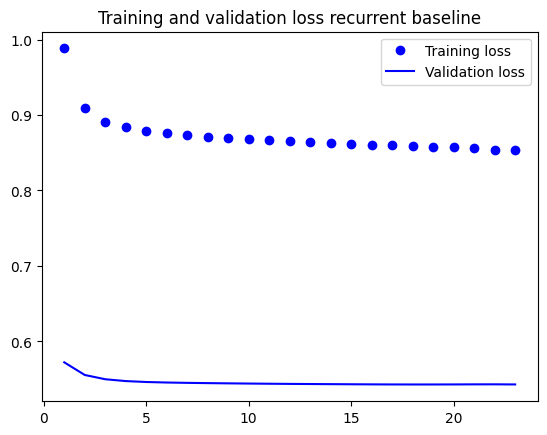

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss recurrent baseline')
plt.legend()
plt.show()


Overfitting occurred.

100 epochs of training with adam (16 units in lstm layer) achieved a val-loss(0.6) lower than the training loss (0.9) with a significant gap between them.

100 epochs of training with adam (16 units in lstm layer):
loss: 1.0346 - mae: 0.6900 - val_loss: 0.5472 - val_mae: 0.4927 - learning_rate: 1.0000e-04

With 16, 32, 128 neurons in simple LSTM model, resulted in huge gap between losses. Validation MAE did not much with increase in number of neurons too. THe performance reamined almost in similar range. with 16 neurons,validation mae resulted in 1.02 and 128 neurons in lstmlayer resulted in 1.03. But with higher number of  neurons stopped training in less number of epochs signifcantly.


Further improvement of performance is necessary

In [ ]:

# load the checkpointed model and compute its test MAE
lstm_model = keras.models.load_model("stemp_lstm.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=lstm_model):.2f}")


Validation MAE lstm: 1.03


***LSTM did not perform  better than baseline model as Validation MAE lstm: 1.03 is lower than the Validation MAE of base line model: 0.73. Hence, LSTM model can beat the baseline model.***

##Stationary timeseries data training on  *stacked recurrent network*

In [ ]:
num_features=df.shape[-1]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

def build_stacked_lstm(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))
  x = layers.GRU(32, return_sequences=True)(inputs)
  x = layers.GRU(32,return_sequences=True)(x)
  x = layers.GRU(32)(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model

stacked_lstm_model= build_stacked_lstm(sequence_length, num_features)
# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("stemp_stacked_lstm.keras",save_best_only=True)

#add a learning rate schedule to reduce the learning rate when validation loss plateaus
rop= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


# AdamW optimizer
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
# Compile with AdamW optimizer and learning rate scheduling
adamw_optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
stacked_lstm_model.compile(optimizer=adamw_optimizer, loss="mse", metrics=["mae"])
history = stacked_lstm_model.fit(train_dataset,
epochs=150,
validation_data=val_dataset,
callbacks=[checkpoint, early_stopping,rop])

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - loss: 1.0699 - mae: 0.7099 - val_loss: 0.5487 - val_mae: 0.4933 - learning_rate: 0.0010
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - loss: 1.0427 - mae: 0.6934 - val_loss: 0.5379 - val_mae: 0.4860 - learning_rate: 0.0010
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step - loss: 1.0293 - mae: 0.6896 - val_loss: 0.5447 - val_mae: 0.4910 - learning_rate: 0.0010
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 432ms/step - loss: 1.0315 - mae: 0.6882 - val_loss: 0.5419 - val_mae: 0.4885 - learning_rate: 0.0010
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step - loss: 1.0209 - mae: 0.6839 - val_loss: 0.5363 - val_mae: 0.4866 - learning_rate: 0.0010
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - loss: 1.0154 - mae: 0.6816 - val_loss: 0.5364 - val_mae: 0.4854 - learning_rate: 0.0010
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - loss: 1.0135 - mae: 0.6814 - val_loss: 0.5343 - val_mae: 0.4843 - learning_rate:

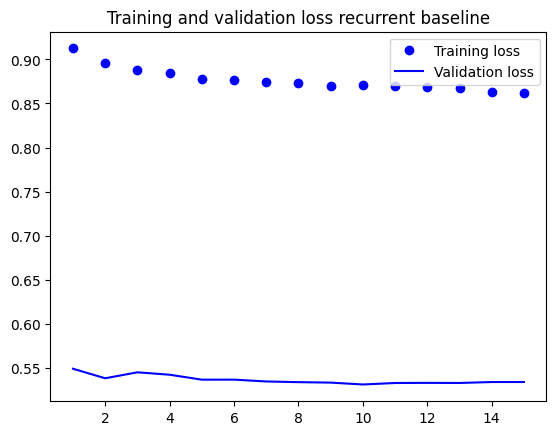

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss recurrent baseline')
plt.legend()
plt.show()

AT 10/150 epochs of LR plateau early stopping callback training:

loss: 1.0307 - mae: 0.6942 - val_loss: 0.5385 - val_mae: 0.4863 - With 32 neurons in hidden layers at learning_rate: 1.0000e-04

Huge gap incurred between losses even though val-loss is lower than training loss

In [ ]:
# load the checkpointed model and compute its test MAE
stacked_lstm_model = keras.models.load_model("stemp_stacked_lstm.keras")

print(f"Validation MAE Stacked lstm on stationary time series data: {evaluate_model(val_dataset, model=stacked_lstm_model):.2f}")


Validation MAE Stacked lstm on stationary time series data: 1.01


Stackd lstm did not perform better than baseline model but a bit better compared to  a simple lstm model in terms of mae as

validation mae of baseline model- 0.73

validation mae of lstm - 1.03

validation mae of stacked lstm - 1.01 (with 32 neurons)



##Hyperband tuning of stationary timeseries data

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
#Referred lab lectures
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import Hyperband

def model_builder(hp):
    # Hyperparameters
    sequence_length = hp.Choice('sequence_length', values=[48, 96, 120, 336])
    num_units = hp.Choice('num_units', values=[16, 32, 64])
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    initial_lr = hp.Float('initial_lr', min_value=1e-4, max_value=1e-2, sampling="log")

    # Learning rate schedule
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10000,
        alpha=1e-2
    )
    optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

    # Model architecture
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = inputs
    for _ in range(num_layers):
        x = layers.GRU(num_units, return_sequences=True)(x)
    x = layers.GRU(num_units)(x)  # Final GRU layer without return_sequences
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model




In [ ]:
#num_features=df.shape[-1]
tuner = Hyperband(
    model_builder,
    objective='val_mae',
    max_epochs=20,
    factor=3,
    directory='hyperband_runs',
    project_name='stationary_time_series_rnn_ElectricityTransformer'
)
#  early stopping to avoid unnecessary long training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,min_delta=1e-4, restore_best_weights=True)
tensorboard = keras.callbacks.TensorBoard(
log_dir="/content/drive/MyDrive/tensorboard_logs/hyperband",
histogram_freq=1
)
#remove the log directory if already exists
!rm -rf "/content/drive/MyDrive/tensorboard_logs/hyperband"
#  the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping,tensorboard],verbose = 1)




Trial 90 Complete [00h 04m 21s]
val_mae: 0.4843488335609436

Best val_mae So Far: 0.4780438244342804
Total elapsed time: 03h 34m 52s


Best model- Validation MAE lstm:  0.48 is better than baseline model(1.95) on given stationary time series data of electricity transformer

In [ ]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters:\n"
      f"Sequence Length: {best_hps.get('sequence_length')}\n"
      f"Num LSTM/GRU Units: {best_hps.get('num_units')}\n"
      f"Num Layers: {best_hps.get('num_layers')}\n"
      f"Dense Units: {best_hps.get('dense_units')}\n"
      f"Dropout Rate: {best_hps.get('dropout_rate')}\n"
      f"Initial Learning Rate: {best_hps.get('initial_lr')}")

Best Hyperparameters:
Sequence Length: 336
Num LSTM/GRU Units: 64
Num Layers: 1
Dense Units: 32
Dropout Rate: 0.5
Initial Learning Rate: 0.006843594197752182


**Best Hyperparameters of best modelon given stationary time series data:**

Sequence Length: 336

Num LSTM/GRU Units: 64

Num Layers: 1

Dense Units: 32

Dropout Rate: 0.5

Initial Learning Rate: 0.006843594197752182

##Best Model from hyperparameter obtained from hyperband tuning

In [ ]:
'''
sequence_length = 336

num_units = 64
num_layers = 1
dense_units = 32
dropout_rate = 0.5
initial_learning_rate = 0.006843594197752182
'''
#sequence length differed from the split data
#sequence_length is the number of past observations you want to use for prediction.
sequence_length = 336
batch_size = 256

#Horizon is the forecasting interval, that is, how many time steps into the future you want to predict.
#Create time series data,
#starting with a sequence_length (i.e., window size) 120; that is, use previous 5 days to predict the
#temperature 96 hours into the future
horizon= 96

# delay is where the index for y should start
delay=sequence_length+horizon-1

stationary_val_dataset = keras.preprocessing.timeseries_dataset_from_array(
data=df[:-delay],
targets=df['OT_diff'][delay:],
sequence_length=sequence_length,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)
num_features=df.shape[-1]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

def st_build_best_lstm(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))
  x = layers.GRU(64, return_sequences=True)(inputs)
  #x = layers.GRU(32)(x)
  x = layers.Dropout(0.5)(x)
  # Add Dense layer with 64 units
  x = layers.Dense(32)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model

st_best_lstm_model= st_build_best_lstm(336, num_features)
# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("best_lstm_stationary_model.keras",save_best_only=True)

#add a learning rate schedule to reduce the learning rate when validation loss plateaus
rop= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


# AdamW optimizer
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
# Compile with AdamW optimizer and learning rate scheduling
adam_optimizer = keras.optimizers.Adam(learning_rate=0.006843594197752182, weight_decay=1e-5)
st_best_lstm_model.compile(optimizer=adam_optimizer, loss="mse", metrics=["mae"])
history = st_best_lstm_model.fit(train_dataset,
epochs=150,
validation_data=stationary_val_dataset,
callbacks=[checkpoint, early_stopping,rop])

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 683ms/step - loss: 1.2691 - mae: 0.8028 - val_loss: 0.5515 - val_mae: 0.5017 - learning_rate: 0.0068
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 632ms/step - loss: 1.0991 - mae: 0.7233 - val_loss: 0.5433 - val_mae: 0.4956 - learning_rate: 0.0068
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 758ms/step - loss: 1.0873 - mae: 0.7158 - val_loss: 0.5371 - val_mae: 0.4890 - learning_rate: 0.0068
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 666ms/step - loss: 1.0843 - mae: 0.7137 - val_loss: 0.5368 - val_mae: 0.4887 - learning_rate: 0.0068
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - loss: 1.0841 - mae: 0.7135 - val_loss: 0.5368 - val_mae: 0.4886 - learning_rate: 0.0068
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 685ms/step - loss: 1.0841 - mae: 0.7135 - val_loss: 0.5368 - val_mae: 0.4886 - learning_rate: 0.0068
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 707ms/step - loss: 1.0842 - mae: 0.7136 - val_loss: 0.5368 - val_mae: 0.4886 - learning_rate:

In [ ]:
# #the following code segment is generated by AI, using the prompt 'give a function which  automatically updates the MAE state across batches and computes the final result'
#Handles shape mis-alignments dynamically
def evaluate_best_model(dataset, model):
    mae_metric = keras.metrics.MeanAbsoluteError()
    for batch in dataset:
        inputs, targets = batch
        predictions = model.predict(inputs)
        mae_metric.update_state(targets, predictions)
    return mae_metric.result().numpy()



In [ ]:
#load the checkpointed model and compute its test MAE
st_best_lstm_model = keras.models.load_model("best_lstm_stationary_model.keras")

print(f"Validation MAE lstm: {evaluate_best_model(stationary_val_dataset, model=st_best_lstm_model):.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Validation MAE lstm: 0.49


Best model built onbest hyperparameters has performed better than  a baseline model.

##1D Conv model training with Stationary time series data of ELectricity Transformer

In [ ]:
sequence_length=120
def build_1dconv(sequence_length, num_features):
  inputs = keras.Input(shape=(sequence_length, num_features))

  # a 1D convolutional layer with 8 filters and a kernel/window of size 24
  x = layers.Conv1D(8, 24, activation="relu")(inputs)
  # a 1D convolutional layer with 8 filters and a kernel of size 24
  x = layers.MaxPooling1D(2)(x)
  # a 1D convolutional layer with 8 filters and a kernel of size 12
  x = layers.Conv1D(8, 12, activation="relu")(x)
  x = layers.MaxPooling1D(2)(x)

  # a 1D convolutional layer with 8 filters and a kernel of size 12
  #x = layers.Conv1D(8, 6, activation="relu")(x)
  #x = layers.MaxPooling1D(2)(x)

  # a 1D convolutional layer with 8 filters and a kernel of size 6
  x = layers.Conv1D(8, 6, activation="relu")(x)
  # a 1D convolutional layer with 8 filters and a kernel of size 3
  x = layers.Conv1D(8, 3, activation="relu")(x)

  # a golobal average pooling layer that takes the global average along the temporal dimension
  x = layers.GlobalAveragePooling1D()(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)
  return model
conv1D_model= build_1dconv(sequence_length, num_features)

conv1D_model.summary()



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 120, 11)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 97, 8)               │           2,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 18, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 13, 8)               │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 11, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,497 (13.66 KB)

 Trainable params: 3,497 (13.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# check point the best model
checkpoint= keras.callbacks.ModelCheckpoint("stemp_conv1d.keras",save_best_only=True)
# Compile the model with learning rate scheduler
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)
adamw_optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
conv1D_model.compile(optimizer=adamw_optimizer, loss="mse", metrics=["mae"])
history = conv1D_model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=[checkpoint, rop])

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 1.1026 - mae: 0.7204 - val_loss: 0.5636 - val_mae: 0.4988 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 1.0820 - mae: 0.7125 - val_loss: 0.5627 - val_mae: 0.4992 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 1.0772 - mae: 0.7104 - val_loss: 0.5632 - val_mae: 0.5004 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 1.0799 - mae: 0.7122 - val_loss: 0.5605 - val_mae: 0.4969 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 1.0726 - mae: 0.7098 - val_loss: 0.5513 - val_mae: 0.4910 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 1.0611 - mae: 0.7025 - val_loss: 0.5543 - val_mae: 0.4957 - learning_rate: 0.0010
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 1.0531 - mae: 0.7011 - val_loss: 0.5435 - val_mae: 0.4879 - learning_rate: 0.0010
Epoch 8/50


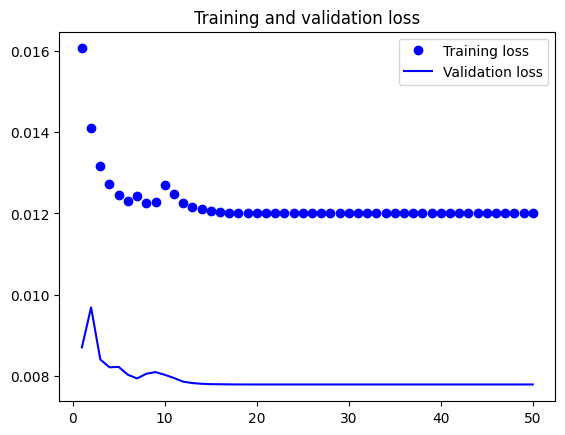

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Huge gap between the losses is observed.

In [ ]:
# load the checkpointed model and compute its test MAE
conv1D_model = keras.models.load_model("stemp_conv1d.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=conv1D_model):.2f}")

Validation MAE lstm: 1.02


**Conv 1D Validation MAE lstm: 1.02 did not perform  better than baseline model(0.73) on given stationary times data of electricity transformer**.Out of all the models after the hyperband tuned best nodel, stacked lstm model(1.01) performed better with stationary time series data whencompared with baseline model(0.73).

##Tuning CONV1D model with  different filters and kernel sizes

In [ ]:
from tensorflow.keras import layers, models

def tuned_build_1dconv(sequence_length, num_features):
    inputs = keras.Input(shape=(sequence_length, num_features))

    # 1st 1D convolutional layer with larger kernel size to capture initial patterns
    x = layers.Conv1D(16, kernel_size=16, activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)

    # 2nd 1D convolutional layer with a moderately smaller kernel size
    x = layers.Conv1D(32, kernel_size=8, activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    # 3rd 1D convolutional layer with smaller kernel size to focus on refined features
    x = layers.Conv1D(64, kernel_size=4, activation="relu")(x)

    # 4th 1D convolutional layer with a minimal kernel size
    x = layers.Conv1D(64, kernel_size=2, activation="relu")(x)

    # Global Average Pooling to reduce overfitting by averaging across time steps
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer for regression
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    return model

tuned_conv1D_model = tuned_build_1dconv(sequence_length, num_features)
tuned_conv1D_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 120, 11)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 105, 16)             │           2,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 52, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 45, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 19, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 18, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,537 (91.94 KB)

 Trainable params: 23,537 (91.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# check point the best model
kcheckpoint= keras.callbacks.ModelCheckpoint("temp_kconv1d.keras",save_best_only=True)
# Compile the model with learning rate scheduler
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
#optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)
adamw_optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5)
conv1D_model.compile(optimizer=adamw_optimizer, loss="mse", metrics=["mae"])
history = conv1D_model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=[kcheckpoint, rop])

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 1.0452 - mae: 0.6957 - val_loss: 0.5446 - val_mae: 0.4916 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 1.0280 - mae: 0.6877 - val_loss: 0.5495 - val_mae: 0.4969 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 1.0245 - mae: 0.6867 - val_loss: 0.6008 - val_mae: 0.5384 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 1.0308 - mae: 0.6911 - val_loss: 0.5500 - val_mae: 0.4948 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 1.0205 - mae: 0.6833 - val_loss: 0.5558 - val_mae: 0.4974 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 1.0222 - mae: 0.6834 - val_loss: 0.5456 - val_mae: 0.4901 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 1.0168 - mae: 0.6810 - val_loss: 0.5475 - val_mae: 0.4913 - learning_rate: 1.0000e-04

In [ ]:
# load the checkpointed model and compute its test MAE
kconv1D_model = keras.models.load_model("temp_kconv1d.keras")

print(f"Validation MAE of  conv1D model tuned with different filters and kernel sizes: {evaluate_model(val_dataset, model=kconv1D_model):.2f}")

Validation MAE of  conv1D model tuned with different filters and kernel sizes: 1.03


**Validation MAE of  conv1D model tuned with different filters and kernel sizes: 1.02**

**Validation MAE of  conv1D model tuned with same sized filter  with different  kernel sizes in different layers: 1.03**

conv1D model did not perform better than a baseline model.

**Conv 1D Validation MAE lstm: 1.02 is not better than baseline model(0.73) on given stationary times data of electricity transformer**.Out of all the models after the hyperband tuned best model, stacked lstm model(1.01) did not perform better with stationary time series data when compared with baseline model(0.73).

## Evaluting the best model on the test data
So far our best model for this dataset was the stacked lstm model. Let's evaluate this model on the test data and compare it to the performance of the commonsense  model on the test data.

## Validation MAE of
**Non-stationary timeseries data(sorted dated data):**

Baseline model - 0.73
LSTM - 1.06
Stacked GRU layered model- 0.73
Hyperband tuned best model with date - 0.70(*50 epochs of tuner search*)
1D conv model-1.09

**Stationary timeseries data:**

Baseline model - 0.73
LSTM - 1.03
Stacked GRU layered model- 1.01
Hyperband tuned best model - 0.49 (*50 epochs of tuner search*)
1D conv model-1.02

**Overall,  stacked lstm model (non-stationary time series data -val-mae:1.01) performed  better with lowest validation loss and also when compared with baseline model (stationary-1.95 and non-stationary time series data-0.73), after  best model obtained from the  hyperband tuned stationary data as the best validation mae achieved was 0.49.**

In [ ]:
print(f"test MAE for commonsense model of stationary time series data : {evaluate_model(test_dataset):.2f}")

test MAE for commonsense model of stationary time series data : 1.76

In [ ]:

print(f"test MAE for best model of stationary time series data: {evaluate_best_model(test_dataset, model=st_best_lstm_model):.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
test MAE for best model of stationary time series data: 0.42


In [ ]:
print(f"test MAE for commonsense model of stationary time series data : {evaluate_model(test_dataset):.2f}")

test MAE for commonsense model of stationary time series data : 1.76


Test MAE for best model of stationary time series data: 0.41

performed than baseline model as

Test MAE for commonsense model of stationary time series data : 1.76



Predictions from best model

In [ ]:
#the following code segment is generated by AI, using the prompt ' Display the column names with their indices and how to find the index of the specific column directly'
for idx, col_name in enumerate(df.columns):
    print(f"Index {idx}: {col_name}")

# Find the index of the specific column directly
temp_column_name = 'OT_diff'  # or 'OT' if 'OT_diff' is not available
temp_index = df.columns.get_loc(temp_column_name)
print(f"The index of '{temp_column_name}' is: {temp_index}")


Index 0: HUFL
Index 1: HULL
Index 2: MUFL
Index 3: MULL
Index 4: LUFL
Index 5: LULL
Index 6: Day y
Index 7: Day x
Index 8: Month y
Index 9: Month x
Index 10: OT_diff
The index of 'OT_diff' is: 10


In [ ]:
print(temp_index)

10


In [ ]:
#the following code segment is generated by AI, using the prompt 'evaluate the model (or baseline) on the dataset and obtain predictions using the above given evalaute_model function.Plot
#the predicted vs true values for test data. ' and later modified code necessarily.
def get_predictions(dataset, model=None):
    preds = []
    targets = []
    temp_index = 10  # Assuming temperature is at index 1 in your data

    for samples, target in dataset:
        if model is None:
            # Baseline: predict the last measurement in the input sequence
            predictions = samples[:, -1, temp_index]
        else:
            # Model-based predictions
            predictions = model.predict(samples, verbose=0).flatten()

        preds.extend(predictions)
        targets.extend(target.numpy().flatten())

    return np.array(preds), np.array(targets)


##Predictions from best model

From best model obtained from hyperband tuning on stationary time series data

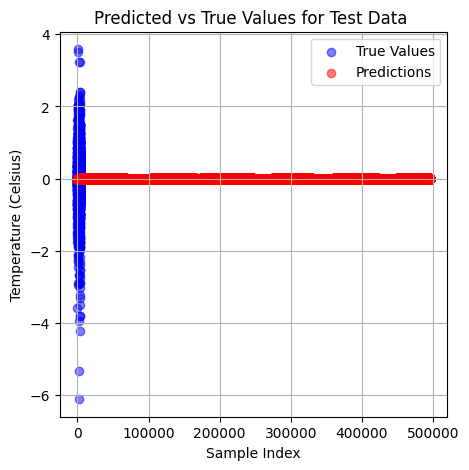

In [ ]:
#the following code segment is generated by AI, using the prompt 'evaluate the model (or baseline) on the dataset and obtain predictions using the above given unnormalize & evalaute_model function.Plot
#the predicted vs true values for test data. ' and later modified code necessarily.
import matplotlib.pyplot as plt
import numpy as np

# Reload the best model from the checkpoint if needed
#stationary_stacked_lstm_model = keras.models.load_model("/content/temp_stacked_lstm.keras")
# Get the predictions and actual test values from the test dataset
best_preds, targets = get_predictions(test_dataset, st_best_lstm_model)

temp_index = 10
# Unnormalize predictions and targets
best_preds, targets = unnormalize(best_preds, targets, train_mean.iloc[temp_index], train_std.iloc[temp_index])
# Plot predicted vs. true values for test data
plt.figure(figsize=(5, 5))
# Plot true values in one color
plt.scatter(range(len(targets)), targets, color='blue', label="True Values", alpha=0.5)

# Plot predictions in another color
plt.scatter(range(len(best_preds)), best_preds, color='red', label="Predictions", alpha=0.5)

plt.xlabel("Sample Index")
plt.ylabel("Temperature (Celsius)")
plt.title("Predicted vs True Values for Test Data ")
plt.legend()
plt.grid(True)
plt.show()



**The best ML model(MAE-0.41) outperforms the commonsense model on the test data(MAE-1.76).**

=============================THE END=========================